In [3]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
import matplotlib.patches as mpatches
from sklearn.preprocessing import Imputer
from sklearn.cluster import KMeans
from wordcloud import WordCloud

In [ ]:
sns.set_style("whitegrid", {'axes.grid' : False})

## Figuring out age and gender of commenters

In [132]:
data = pickle.load(open('data/merged.dat', 'rb'))
data_without_sub_com = data[~data.comment_is_submitter]

In [4]:
for index, row in tqdm(data.iterrows()):
    selected = data[data.post_author == row.comment_author]
    selected_gender = selected.post_gender[selected.post_gender != 'unknown'].dropna().values
    if len(selected_gender) > 0:
        data.at[index, 'comment_author_gender'] = selected_gender[0]
    selected_age = selected.post_age[selected.post_age > 0].dropna().values
    if len(selected_age) > 0:
        data.at[index, 'comment_author_age'] = selected_age[0]

294468it [2:16:09, 36.04it/s]


In [ ]:
# save it

## Working with it further

In [3]:
data = pickle.load(open('data/merged.dat', 'rb'))

In [46]:
# sns.jointplot(x='comment_rating', y='comment_author_age', data=data)
# # not a very interesting plot

## Figure out what ratings genders give each other

In [133]:
ratings_m = data_without_sub_com[data_without_sub_com.comment_author_gender == 'male'].groupby('comment_author').mean()['comment_rating'].values
ratings_f = data_without_sub_com[data_without_sub_com.comment_author_gender == 'female'].groupby('comment_author').mean()['comment_rating'].values

In [134]:
ratings_m = ratings_m[~np.isnan(ratings_m)]
ratings_f = ratings_f[~np.isnan(ratings_f)]

In [138]:
print(ratings_m.shape[0], ratings_f.shape[0])
# turns out males are 3 times more active commenters based on limited data about commenter gender
# maybe

2616 882


In [144]:
posts_num_male = data[data.post_gender == 'male'].post_id.unique().shape
posts_num_female = data[data.post_gender == 'female'].post_id.unique().shape

In [145]:
print(posts_num_male, posts_num_female)

(19333,) (5711,)


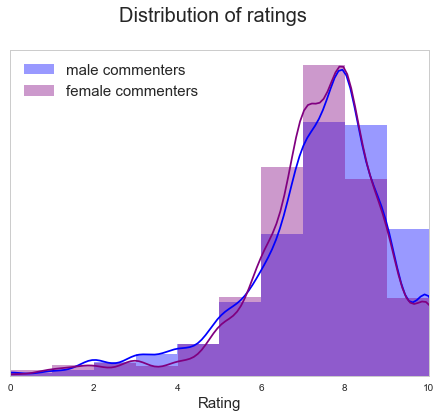

In [140]:
fig,ax = plt.subplots(1, figsize=(7.5, 6))
sns.distplot(ratings_m, bins=10, color='blue', label='male commenters')
sns.distplot(ratings_f, bins=10, color='purple', label='female commenters')
plt.legend(fontsize=15)
plt.xlim(0, 10)
plt.xlabel('Rating', fontsize=15)
ax.set_yticklabels([])
# plt.tight_layout()
plt.suptitle('Distribution of ratings', fontsize=20)

In [128]:
ratings_mtof = data_without_sub_com[(data_without_sub_com.comment_author_gender == 'male') &
                    (data_without_sub_com.post_gender == 'female')].groupby('comment_author').mean()['comment_rating'].values
ratings_ftof = data_without_sub_com[(data_without_sub_com.comment_author_gender == 'female') &
                    (data_without_sub_com.post_gender == 'female')].groupby('comment_author').mean()['comment_rating'].values
ratings_mtom = data_without_sub_com[(data_without_sub_com.comment_author_gender == 'male') &
                    (data_without_sub_com.post_gender == 'male')].groupby('comment_author').mean()['comment_rating'].values
ratings_ftom = data_without_sub_com[(data_without_sub_com.comment_author_gender == 'female') &
                    (data_without_sub_com.post_gender == 'male')].groupby('comment_author').mean()['comment_rating'].values

In [129]:
ratings_mtof = ratings_mtof[~np.isnan(ratings_mtof)]
ratings_ftof = ratings_ftof[~np.isnan(ratings_ftof)]
ratings_mtom = ratings_mtom[~np.isnan(ratings_mtom)]
ratings_ftom = ratings_ftom[~np.isnan(ratings_ftom)]

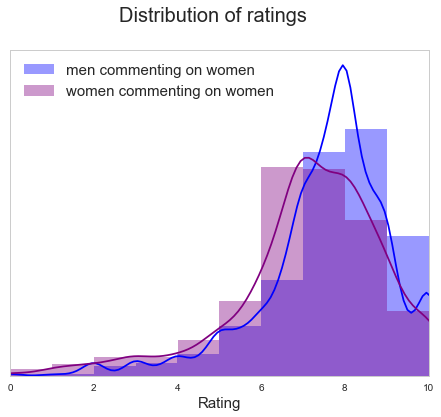

In [130]:
fig,ax = plt.subplots(1, figsize=(7.5, 6))
sns.distplot(ratings_mtof, bins=10, color='blue', label='men commenting on women')
sns.distplot(ratings_ftof, bins=10, color='purple', label='women commenting on women')
plt.legend(fontsize=15)
plt.xlim(0, 10)
plt.xlabel('Rating', fontsize=15)
ax.set_yticklabels([])
# plt.tight_layout()
plt.suptitle('Distribution of ratings', fontsize=20)

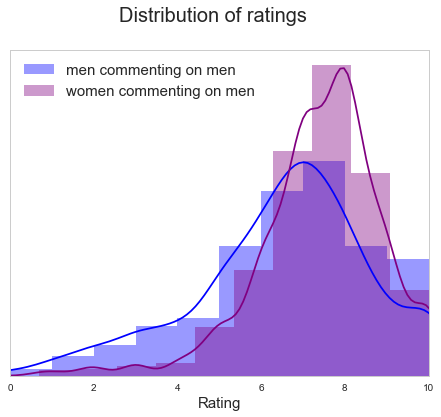

In [131]:
fig,ax = plt.subplots(1, figsize=(7.5, 6))
sns.distplot(ratings_mtom, bins=10, color='blue', label='men commenting on men')
sns.distplot(ratings_ftom, bins=10, color='purple', label='women commenting on men')
plt.legend(fontsize=15)
plt.xlim(0, 10)
plt.xlabel('Rating', fontsize=15)
ax.set_yticklabels([])
# plt.tight_layout()
plt.suptitle('Distribution of ratings', fontsize=20)

## Distribution of avg rating of commenter

In [94]:
grouped1 = data[data.comment_author_num_comments > 5].groupby('comment_author').mean()
# also plotted avg ratings of people with >25 and >125 comments, no differences except for averages
# getting closer to the overall mean
ratings1 = grouped1['comment_rating'].values
ratings1 = ratings1[~np.isnan(ratings1)]

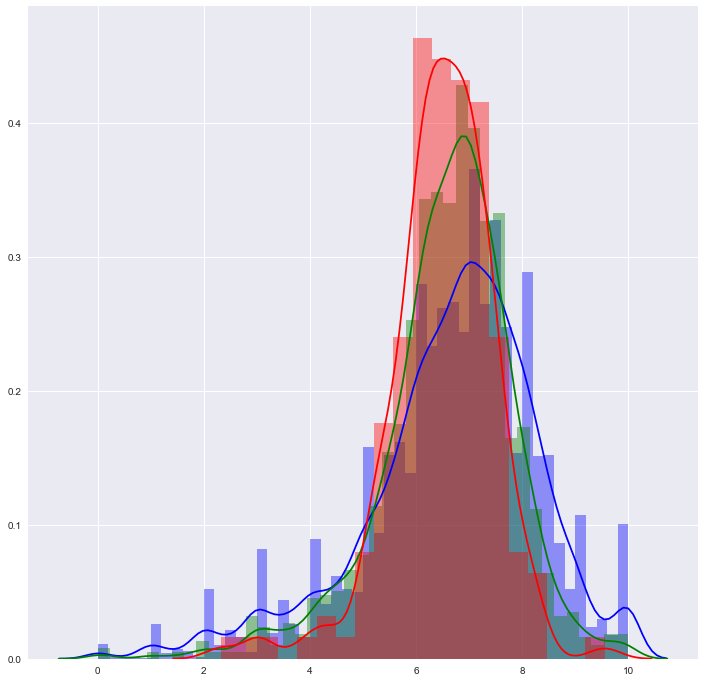

In [97]:
plt.figure(figsize=(12, 12))
sns.distplot(ratings1, color='blue')

## Rating per OP's age (for males and females separately)

In [147]:
age_ratings_female = []
ages_female = range(18, 30)
for age in ages_female:
    age_posts = data[(data.post_gender == 'female') & (data.post_age == age) & (data.comment_author_gender == 'male')]
    ratings_mean = age_posts.comment_rating.mean()
    age_ratings_female.append(ratings_mean)

In [148]:
age_ratings_male = []
ages_male = range(18, 30)
for age in ages_male:
    age_posts = data[(data.post_gender == 'male') & (data.post_age == age) & (data.comment_author_gender == 'female')]
    ratings_mean = age_posts.comment_rating.mean()
    age_ratings_male.append(ratings_mean)

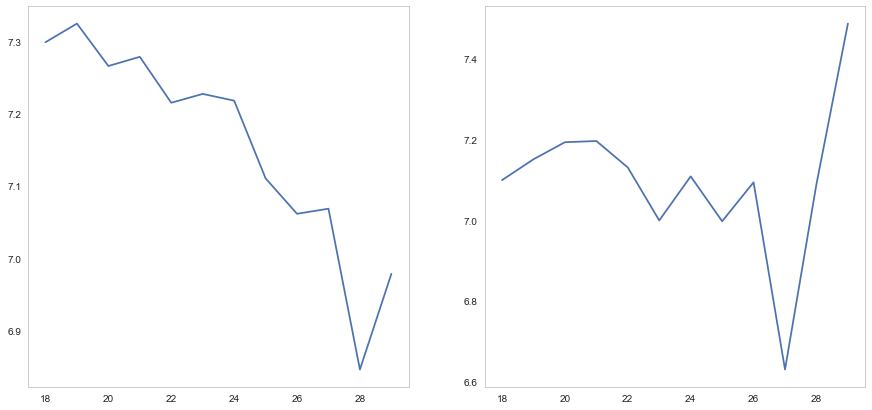

In [155]:
plt.suptitle('Rating vs age (female)')
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
# ax1.figure(figsize=(8, 8))
ax1.plot(ages_female, age_ratings_female)
ax2.plot(ages_male, age_ratings_male)

## Clustering commenters (half-assed attempt)

In [125]:
# data[data.comment_author =='diggydoc']

In [123]:
commenters = data[data.comment_author_num_comments >= 3].comment_author.unique()
all_features = []

In [124]:
for commenter in tqdm(commenters):
    features = []
    
    commenter_data = data[data.comment_author == commenter]
    commenter_data_male = commenter_data[commenter_data.post_gender == 'male']
    commenter_data_female = commenter_data[commenter_data.post_gender == 'female']

    # num of male posts vs female posts commented on
    features.append(commenter_data_male.shape[0])
    features.append(commenter_data_female.shape[0])
    
    # mean, var post_age for male, female posts
    post_age_male = commenter_data_male[commenter_data_male.post_age != 0].post_age
    post_age_female = commenter_data_female[commenter_data_female.post_age != 0].post_age
    features.append(post_age_male.mean())
    features.append(post_age_male.var())
    features.append(post_age_female.mean())
    features.append(post_age_female.var())
    
    features.append(commenter_data_male.comment_rating.mean())
    features.append(commenter_data_male.comment_rating.var())
    features.append(commenter_data_female.comment_rating.mean())
    features.append(commenter_data_female.comment_rating.var())
    features.append(commenter_data_male.comment_score.mean())
    features.append(commenter_data_male.comment_score.var())
    features.append(commenter_data_female.comment_score.mean())
    features.append(commenter_data_female.comment_score.var())
    features.append(1 if commenter_data.iloc[0].comment_author_gender == 'male' else 0)
    features.append(1 if commenter_data.iloc[0].comment_author_gender == 'female' else 0)
    features.append(commenter_data.iloc[0].comment_author_age)
    features.append(commenter_data.comment_body_len.mean())
    features.append(commenter_data.comment_body_len.var())
    features.append(commenter_data.iloc[0].comment_author_num_comments)
    
    all_features.append(features)

100%|████████████████████████████████████████████████████████████████████████████| 20518/20518 [10:52<00:00, 31.42it/s]


In [127]:
all_features_array = np.array(all_features)

In [128]:
all_features_array.shape

(20518, 20)

In [135]:
# np.save('all_features_array.npy', all_features_array)

In [137]:
imputer = Imputer()

In [140]:
imputed = imputer.fit_transform(all_features_array)

In [145]:
kmeans = KMeans(n_clusters=2)
kmeans = kmeans.fit(imputed)

In [146]:
kmeans.cluster_centers_

array([[  4.26528523e+00,   7.59449049e+00,   2.25723884e+01,
          1.96316657e+01,   2.13218575e+01,   9.89658817e+00,
          6.35953742e+00,   3.71941267e+00,   6.92593452e+00,
          3.02932571e+00,   1.78304061e+00,   6.44566239e+00,
          2.00081313e+00,   2.49077974e+01,   2.31058020e-01,
          1.22428084e-01,   2.21539768e+01,   1.01909539e+02,
          1.48785355e+04,   1.21469039e+01],
       [  5.50000000e+00,   2.12500000e+00,   2.14880311e+01,
          8.87686959e+00,   2.30257076e+01,   6.75364933e+00,
          5.08880740e+00,   4.83032030e+00,   5.63771612e+00,
          3.02932571e+00,   2.48809078e+00,   3.69799871e+00,
          4.75368362e+00,   3.35831780e+01,   1.25000000e-01,
          1.38777878e-17,   2.25098511e+01,   1.20614940e+03,
          4.49006105e+06,   7.62500000e+00]])

## Attention of seasoned commenters to men vs women

In [206]:
commenters = data[data.comment_author_num_comments >= 30].comment_author.unique()
# commenters = data[(data.comment_author_num_comments >= 5) & (data.comment_author_num_comments < 300)].comment_author.unique()
# commenters = data[(data.comment_author_num_comments >= 30) & (data.comment_author_num_comments < 300)].comment_author.unique()
comment_nums = []
for commenter in tqdm(commenters):
    commenter_data = data[data.comment_author == commenter]
    commenter_data_male = commenter_data[commenter_data.post_gender == 'male']
    commenter_data_female = commenter_data[commenter_data.post_gender == 'female']
    comment_nums.append((commenter_data_male.shape[0], commenter_data_female.shape[0]))

100%|██████████████████████████████████████████████████████████████████████████████| 1364/1364 [00:39<00:00, 34.58it/s]


In [207]:
comment_nums_array = np.array(comment_nums)

In [167]:
b = comment_nums_array.copy()

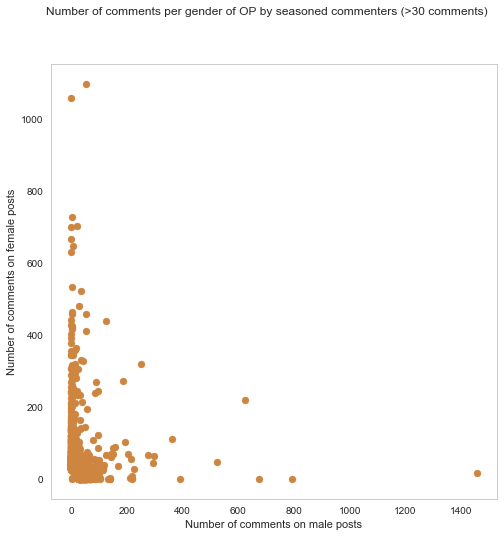

In [215]:
plt.figure(figsize=(8, 8))
plt.suptitle('Number of comments per gender of OP by seasoned commenters (>30 comments)')
plt.scatter(comment_nums_array[..., 0], comment_nums_array[..., 1], color='peru')
plt.xlabel('Number of comments on male posts')
plt.ylabel('Number of comments on female posts')

## How ratings of folks who posted themselves are different from ratings of folks who never posted?

Failed because I only have gender info on people who had posted

In [76]:
submitters = set(data[data.comment_is_submitter].comment_author.values)

In [77]:
commenters = set(data.comment_author.values)

In [78]:
non_submitters = commenters - submitters

In [163]:
data[data.comment_author.isin(submitters)].comment_rating.mean()

6.356776836505441

In [164]:
data[data.comment_author.isin(non_submitters)].comment_rating.mean()

6.886456110719221

In [79]:
# post_gender = 'male'
# comment_author_gender = 'male'
# non_submitters_ratings = data[data.comment_author.isin(non_submitters) & (data.post_gender == post_gender)
#      & (data.comment_author_gender == comment_author_gender)].comment_rating
# submitters_ratings = data[data.comment_author.isin(submitters) & (data.post_gender == post_gender)
#      & (data.comment_author_gender == comment_author_gender)].comment_rating
non_submitters_ratings = data[data.comment_author.isin(non_submitters)].comment_rating
submitters_ratings = data[data.comment_author.isin(submitters)].comment_rating
non_submitters_ratings = non_submitters_ratings[~np.isnan(non_submitters_ratings)]
submitters_ratings = submitters_ratings[~np.isnan(submitters_ratings)]

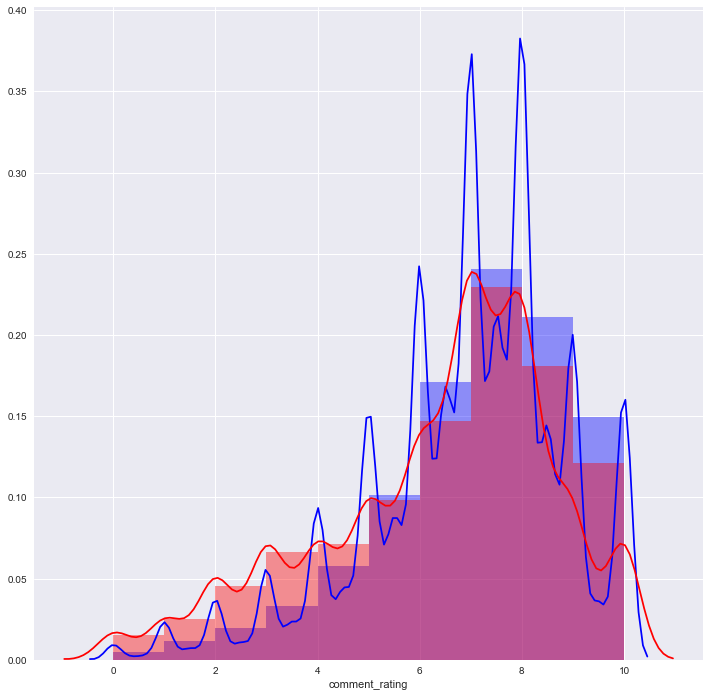

In [80]:
plt.figure(figsize=(12, 12))
sns.distplot(non_submitters_ratings, bins=10, color='blue')
sns.distplot(submitters_ratings, bins=10, color='red')

## Trying to find comment_author_age and post_age/comment_rating correlations

In [241]:
com_age_data = data[(data.comment_author_age == 21) & (data.comment_author_gender == 'male')
                    & (data.post_gender == 'female')]

In [242]:
age_ratings = com_age_data[['post_age', 'comment_rating']].dropna().values

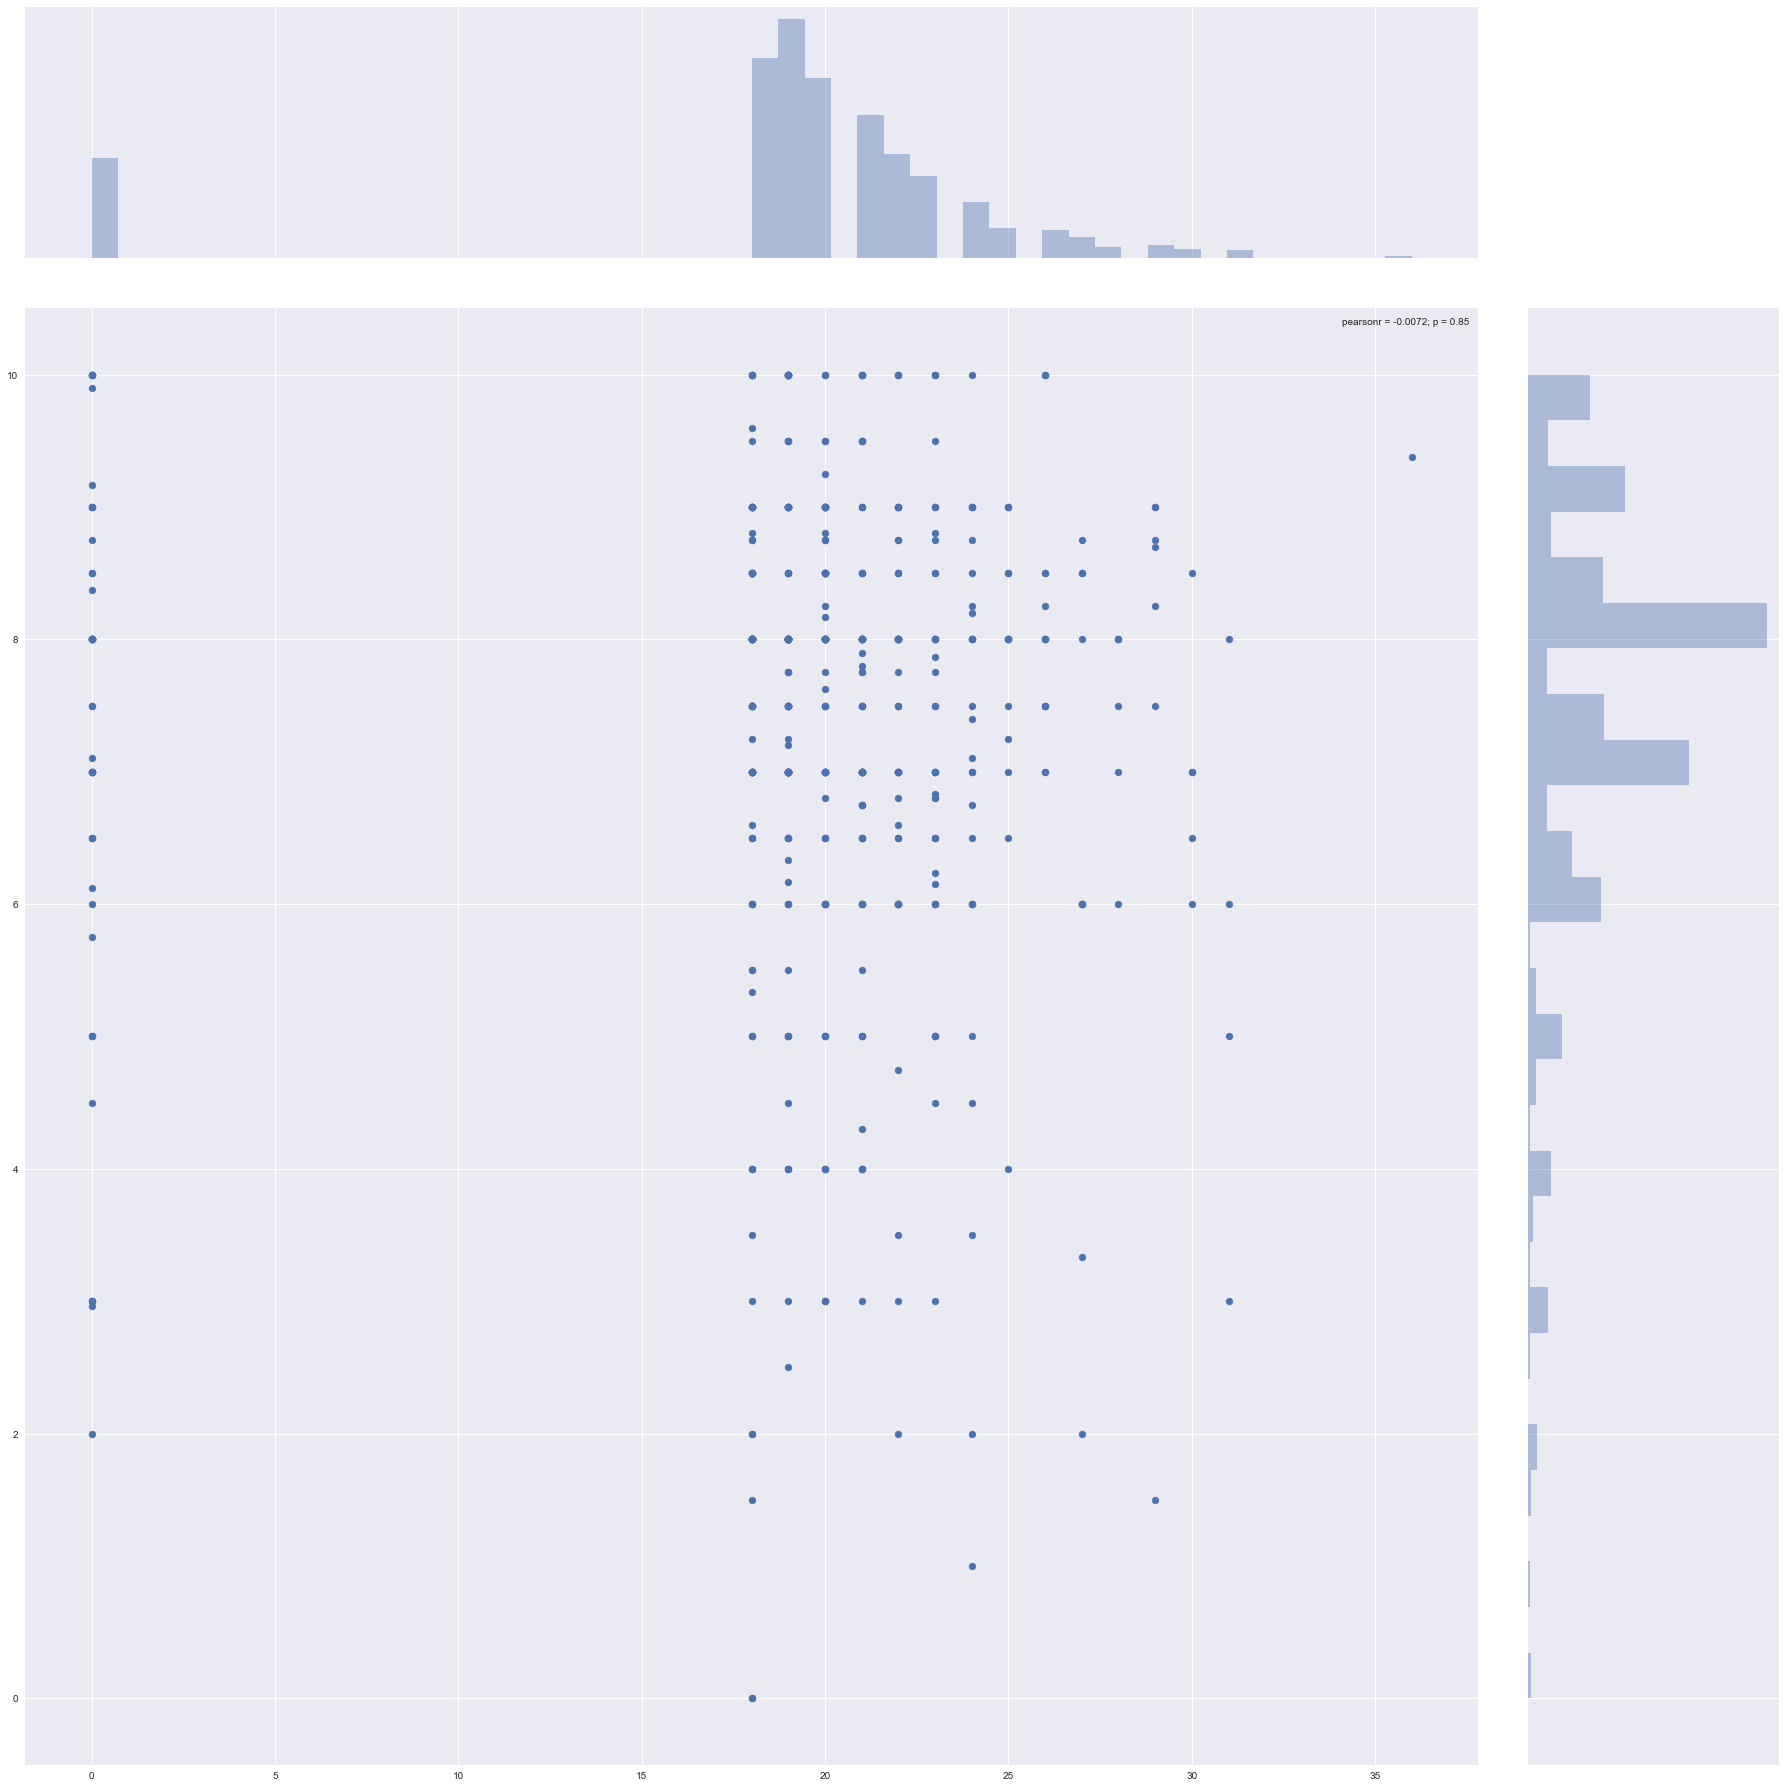

In [243]:
sns.jointplot(age_ratings[..., 0], age_ratings[..., 1], size=25)

## Word clouds

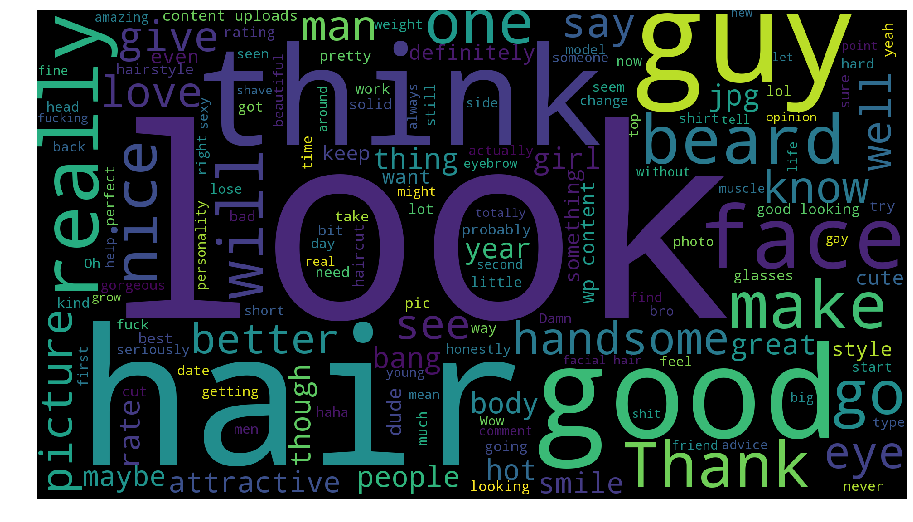

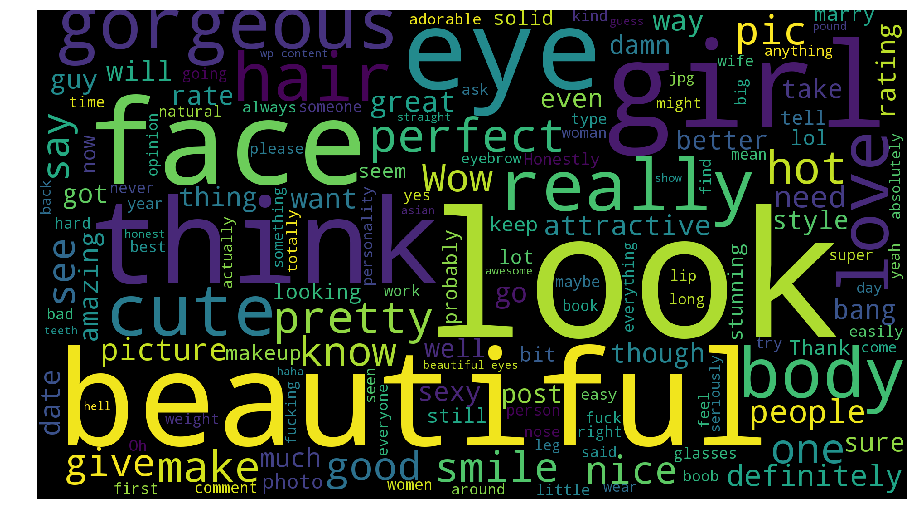

In [223]:
for gender in ['male', 'female']:
    comments = data[(data.comment_rating == 10) & (data.post_gender == gender)].comment_body.values
    word_list = []
    for comment in comments:
        comment_words = comment.split()
        word_list.extend(comment_words)
    text = ' '.join(word_list)
    wordcloud = WordCloud(width=1920, height=1080, max_words=150).generate(text)
    plt.figure(figsize=(16, 9))
    plt.imshow(wordcloud)
    plt.axis("off")

And responses from submitters

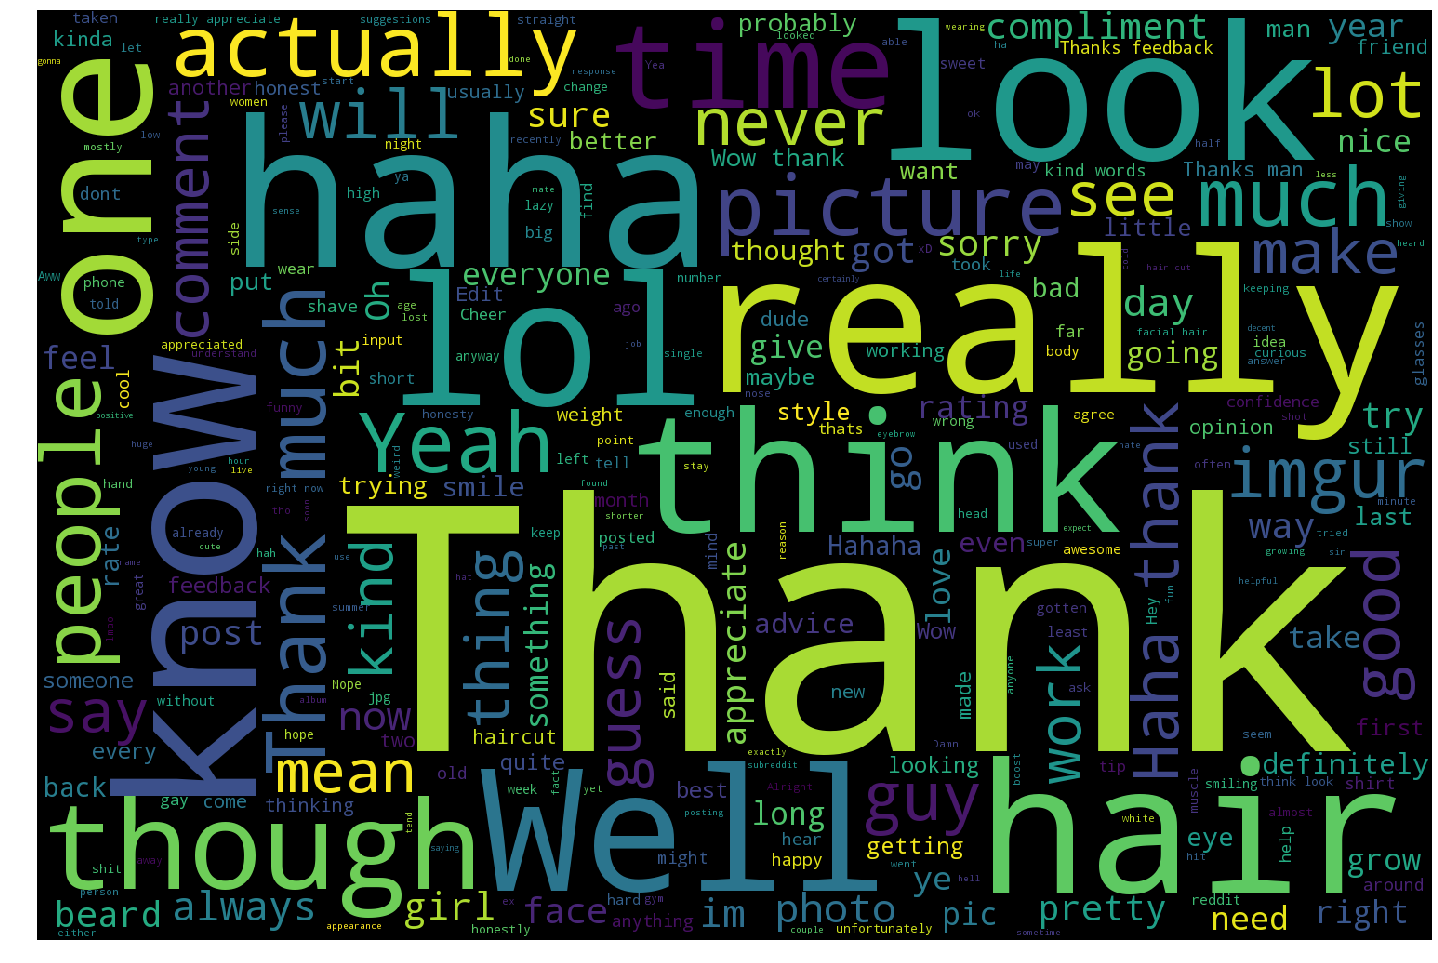

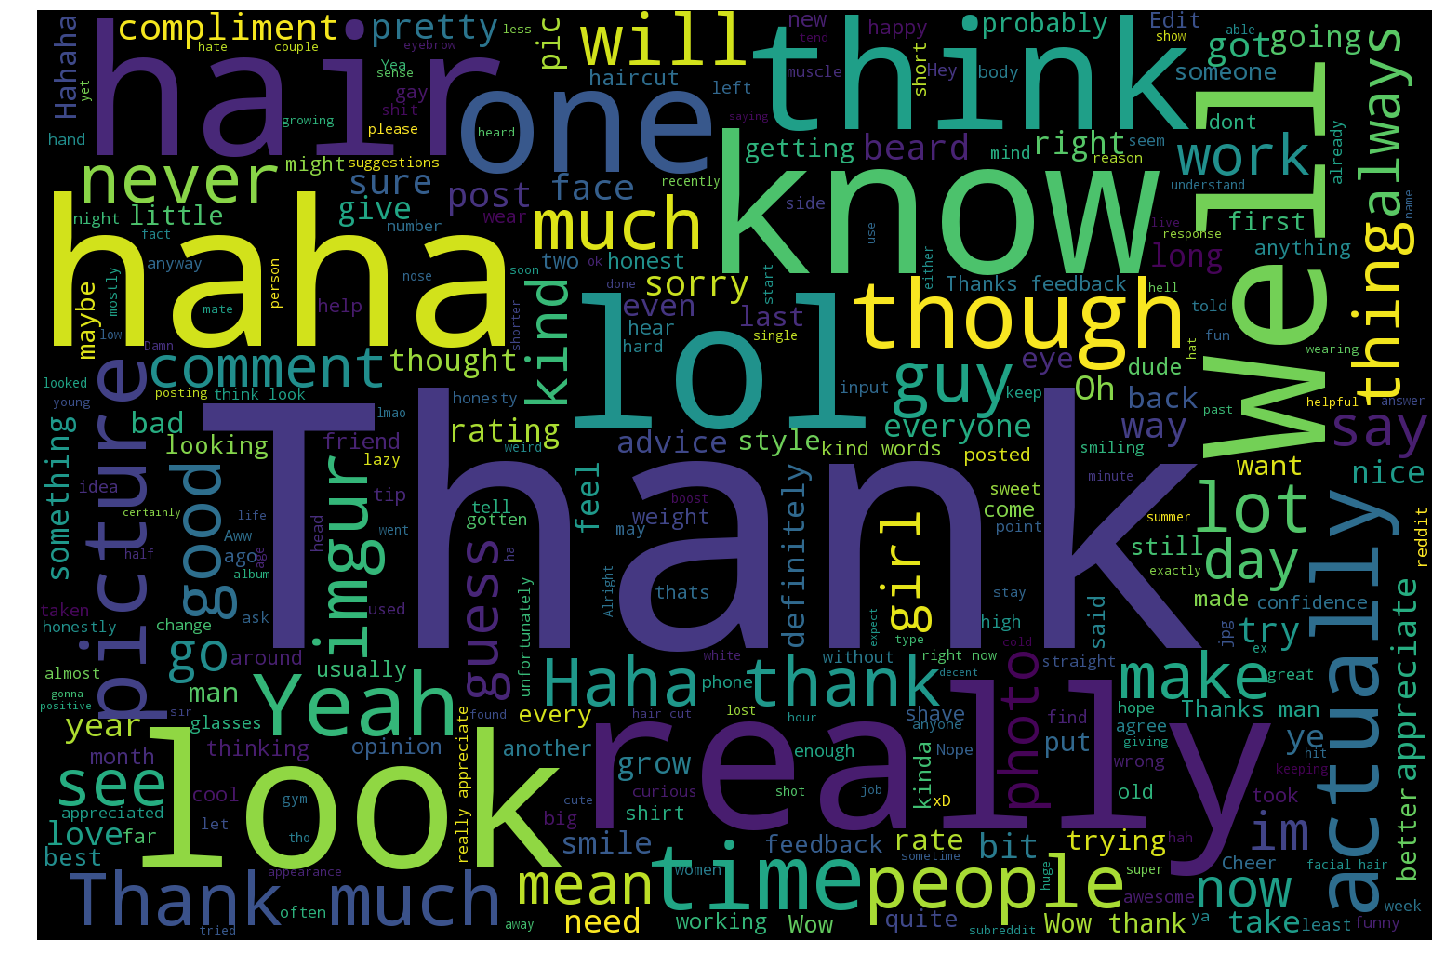

In [68]:
for gender in ['male', 'female']:
    comment_ratings = data.groupby('post_id').mean().comment_rating
    winning_ids = comment_ratings.index[comment_ratings > 8.5].tolist()
    comments = data[(data.post_id.isin(winning_ids)) & (data.comment_is_submitter)].comment_body.values
    word_list = []
    for comment in comments:
        comment_words = comment.split()
        word_list.extend(comment_words)
    text = ' '.join(word_list)
    wordcloud = WordCloud(width=1500, height=1000, max_words=300).generate(text)
    plt.figure(figsize=(25, 25))
    plt.imshow(wordcloud)
    plt.axis("off")

## Write final version of the dataset

In [246]:
data.to_csv('rateme.csv', encoding='utf-8')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (0,2,3,4,5,13,14,15,16,17,18,19,20,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [257]:
data_new = pd.read_csv('rateme.csv', index_col=0, encoding='utf-8', low_memory=False,
                       lineterminator='\n', parse_dates=['post_created', 'comment_created'])

In [258]:
data.shape

(294468, 33)

In [259]:
data_new.shape

(294468, 33)